In [25]:
import pandas as pd
import numpy as np


# Part 1: Data preparation

## Import TCGA normalized RNA-seq expression data

df=pd.read_csv("./rnaseq_FPKM_UQ_all.csv", low_memory=False,index_col=1)
df_tumor=df[df['sample_type']=='Tumor']

# gene expression values # 1109 by 56716
df_tumor_gene=df_tumor.iloc[:,1:56717]
df_tumor_gene.index.names=['barcode']

# clinical information   # 1109 by 82
df_tumor_clinical=df_tumor.iloc[:,56717:]
df_tumor_clinical=df_tumor_clinical.set_index('barcode')

# from IPython.display import display

# pd.options.display.max_columns = None

# df_tumor_clinical.describe(include='all')

# select clinical information   # 1109 by 8


df_tumor_clinical_keep=df_tumor_clinical[['age_at_diagnosis','definition','primary_diagnosis','tumor_stage','gender',
                                            'race','ethnicity']]

data_y=df_tumor_clinical[["vital_status","days_to_last_follow_up","days_to_death"]].copy()
time_to_event=[]
status=[]
for index, row in data_y.iterrows():
    if row['vital_status']=='dead':
        time_to_event.append(row['days_to_death'])
        status.append(1)
    elif row['vital_status']=='alive':
        time_to_event.append(row['days_to_last_follow_up'])
        status.append(0)
    else:
        time_to_event.append(None)
        status.append(None)

y=data_y.copy()
y['status']= pd.Series([x==1 for x in status], index=data_y.index)
y['time_to_event']= pd.Series(time_to_event, index=data_y.index)
y = y.drop(['days_to_last_follow_up','days_to_death','vital_status'], 1)


df2=pd.merge(df_tumor_clinical_keep, y, left_index=True, right_index=True, how='left')

df2 = df2.dropna()

#df2=pd.get_dummies(df2)
df_all=pd.merge(df_tumor_gene, df2, left_index=True, right_index=True, how='right')


df_all.to_csv("./rnaseq_defined.csv", sep='\t')



In [26]:
df_all.shape

(1091, 56725)

In [56]:
# Clinical information further processed in R 

df_clinical=pd.read_csv('./rnaseq_defined_clinical.csv',index_col=0)

# merge back

df_gene=df_all.iloc[:,1:56716]

df_final=pd.merge(df_gene, df_clinical, left_index=True, right_index=True, how='left')

# output
df_final.to_csv("./rnaseq_defined_final.csv", sep='\t')


In [57]:
df_final.to_csv("./rnaseq_defined_final.csv", sep='\t')

# Censoring distributions

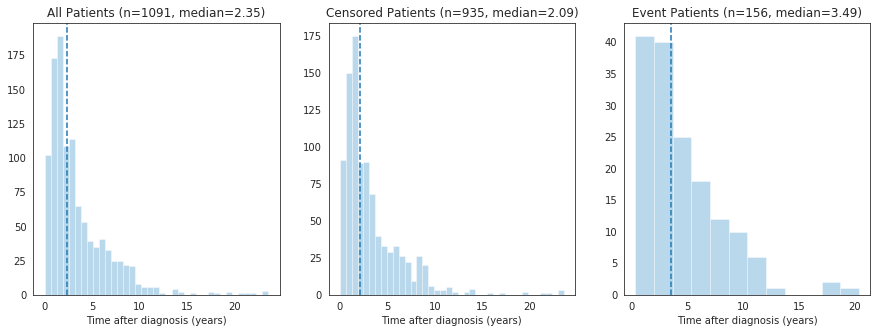

In [150]:

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

y1=df_final[['status','time_to_event']].copy()
y2=y1[y1['status']==False]
y3=y1[y1['status']==True]

y1_median=np.median(y1['time_to_event'])
y2_median=np.median(y2['time_to_event'])
y3_median=np.median(y3['time_to_event'])

Counter(df_y['status'])

sns.set_style('white')
fig, axs = plt.subplots(ncols=3,figsize=(15,5))
sns.distplot(y1['time_to_event'], kde=False, ax=axs[0],color=sns.color_palette("Blues_r")[2])
sns.distplot(y2['time_to_event'], kde=False, ax=axs[1],color=sns.color_palette("Blues_r")[2])
sns.distplot(y3['time_to_event'], kde=False, ax=axs[2],color=sns.color_palette("Blues_r")[2])

axs[0].set_title("All Patients (n=1091, median=2.35)")
axs[1].set_title("Censored Patients (n=935, median=2.09)")
axs[2].set_title("Event Patients (n=156, median=3.49)")

axs[0].axvline(y1_median, linestyle='--')
axs[1].axvline(y2_median, linestyle='--')
axs[2].axvline(y3_median, linestyle='--')

axs[0].set(xlabel='Time after diagnosis (years)')
axs[1].set(xlabel='Time after diagnosis (years)')
axs[2].set(xlabel='Time after diagnosis (years)')


plt.savefig('Histogram_TCGA_BRCA.png',dpi=600,bbox_inches='tight')

In [35]:
Counter(df_final['status'])

Counter({False: 935, True: 156})

In [36]:
print(y1_median)
print(y2_median)
print(y3_median)

2.35
2.09
3.4850000000000003


# Barplots for clinical features

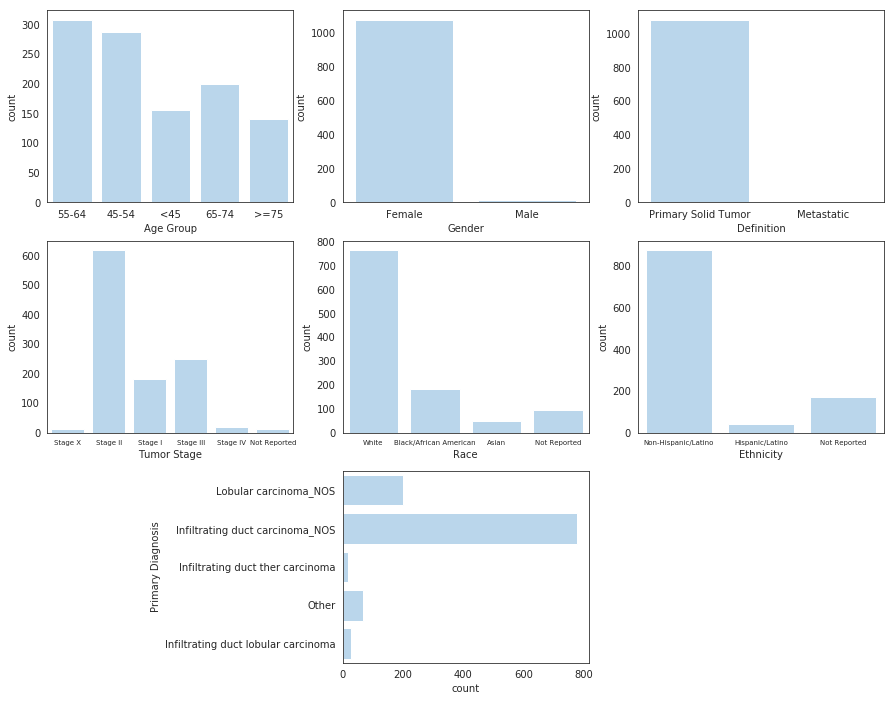

In [151]:
sns.set_style('white')
fig, axs = plt.subplots(ncols=3,nrows=3,figsize=(15,12))
sns.countplot(x="age_group", data=df_clinical,color=sns.color_palette("Blues_r")[4],ax=axs[0,0],saturation=1)
sns.countplot(x="gender", data=df_clinical,color=sns.color_palette("Blues_r")[4],ax=axs[0,1],saturation=1)
sns.countplot(x="definition", data=df_clinical,color=sns.color_palette("Blues_r")[4],ax=axs[0,2],saturation=1)
sns.countplot(x="tumor_stage", data=df_clinical,color=sns.color_palette("Blues_r")[4],ax=axs[1,0],saturation=1)
sns.countplot(x="race", data=df_clinical,color=sns.color_palette("Blues_r")[4],ax=axs[1,1],saturation=1)
sns.countplot(x="ethnicity", data=df_clinical,color=sns.color_palette("Blues_r")[4],ax=axs[1,2],saturation=1)
sns.countplot(y="primary_diagnosis", data=df_clinical,color=sns.color_palette("Blues_r")[4],ax=axs[2,1],saturation=1,orient='h')
fig.delaxes(axs[2][0])
fig.delaxes(axs[2][2])

axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), fontsize=7)
axs[1,1].set_xticklabels(axs[1,1].get_xticklabels(), fontsize=7)
axs[1,2].set_xticklabels(axs[1,2].get_xticklabels(), fontsize=7)

axs[0,0].set_xlabel("Age Group")
axs[0,1].set_xlabel("Gender")
axs[0,2].set_xlabel("Definition")
axs[1,0].set_xlabel("Tumor Stage")
axs[1,1].set_xlabel("Race")
axs[1,2].set_xlabel("Ethnicity")
axs[2,1].set_ylabel("Primary Diagnosis")

plt.savefig('Barplots_TCGA_BRCA.png',dpi=600,bbox_inches='tight')
